In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from bs4 import BeautifulSoup
import requests
import glob

In [3]:
# # 파일 경로 패턴 설정 (여기서는 forecast_*.csv 파일만 가져옴)
# file_list = glob.glob('../data/raw/forecast_*.csv')

# # 모든 파일을 읽어서 하나의 데이터프레임으로 합치기
# df_list = [pd.read_csv(file, encoding='euc-kr') for file in file_list]
# forecast_df = pd.concat(df_list, ignore_index=True)

# # CSV 파일로 저장
# forecast_df.to_csv('../data/processed/forecast_merged2.csv', index=False)


In [4]:
# 파일 경로 설정
file_path = '../data/processed/forecast_merged2.csv'
forecast_df = pd.read_csv(file_path)


#일시 데이트타임 적용
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'])
forecast_df['연도'] = forecast_df['일시'].dt.year
forecast_df['월'] = forecast_df['일시'].dt.month
forecast_df['일'] = forecast_df['일시'].dt.day
forecast_df['시간'] = forecast_df['일시'].dt.hour
forecast_df['요일'] = forecast_df['일시'].dt.day_name().str[:3]

# 결측치 제거
forecast_df.fillna(0, inplace=True)

#데이터 타입 숫자인지 확인????
numeric_columns = forecast_df.select_dtypes(include=['float64', 'int64']).columns
forecast_df[numeric_columns] = forecast_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


# 결과 확인
forecast_df.head(-5)

,지점,일시,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),연도,월,일,시간,요일
0,22105,2020-01-01 00:00:00,6.4,284.0,9.3,1027.5,48.0,3.2,14.8,3.5,2.0,1.4,8.0,41.0,2020,1,1,0,Wed
1,22105,2020-01-01 01:00:00,6.6,309.0,9.6,1026.7,44.0,3.0,14.8,3.7,1.9,1.4,8.0,45.0,2020,1,1,1,Wed
2,22105,2020-01-01 02:00:00,7.3,292.0,10.7,1026.6,50.0,3.4,14.8,3.4,2.2,1.6,8.0,43.0,2020,1,1,2,Wed
3,22105,2020-01-01 03:00:00,7.7,294.0,11.1,1026.6,47.0,2.8,14.8,3.2,1.9,1.3,5.8,22.0,2020,1,1,3,Wed
4,22105,2020-01-01 04:00:00,7.4,292.0,10.5,1025.9,54.0,3.1,14.8,3.1,2.0,1.4,8.0,45.0,2020,1,1,4,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336095,22302,2025-01-12 14:00:00,12.8,308.0,15.6,1016.1,71.0,5.0,13.5,4.3,2.3,1.5,7.7,357.0,2025,1,12,14,Sun
336096,22302,2025-01-12 15:00:00,12.7,306.0,16.8,1016.2,70.0,5.3,13.5,3.6,2.2,1.5,6.5,335.0,2025,1,12,15,Sun
336097,22302,2025-01-12 16:00:00,13.9,310.0,16.5,1016.4,71.0,5.4,13.5,3.9,2.4,1.6,7.4,343.0,2025,1,12,16,Sun
336098,22302,2025-01-12 17:00:00,13.3,300.0,16.5,1016.6,70.0,5.6,13.4,4.5,2.6,1.6,8.0,341.0,2025,1,12,17,Sun


In [5]:
# 실시간 추가(셀레니움?) -- 강사님께 제지당함

# url = 'https://data.kma.go.kr/data/sea/selectBuoyRltmList.do?pgmNo=52'

# # 2️⃣ HTTP 요청을 보내서 웹 페이지 가져오기
# response = requests.get(url)

# # 3️⃣ BeautifulSoup을 사용해 HTML 파싱
# soup = BeautifulSoup(response.text, 'html.parser')

# # 4️⃣ 원하는 데이터 추출 (예: 모든 제목 태그 <h1>)
# titles = soup.find_all('h1')

# # 5️⃣ 추출한 데이터를 출력
# for title in titles:
#     print(title.get_text())

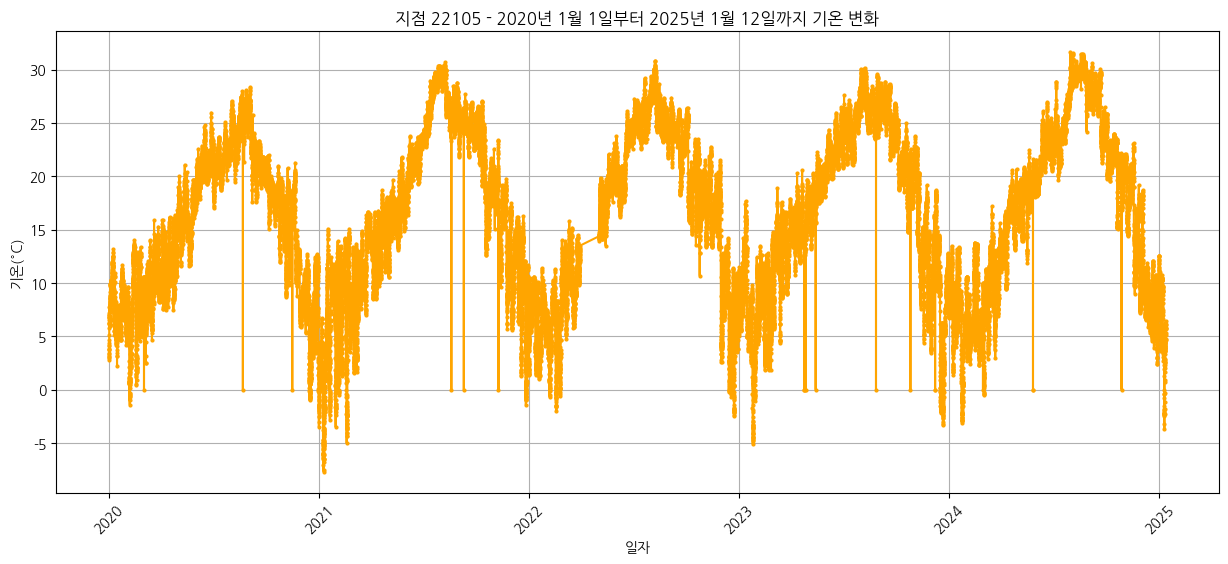

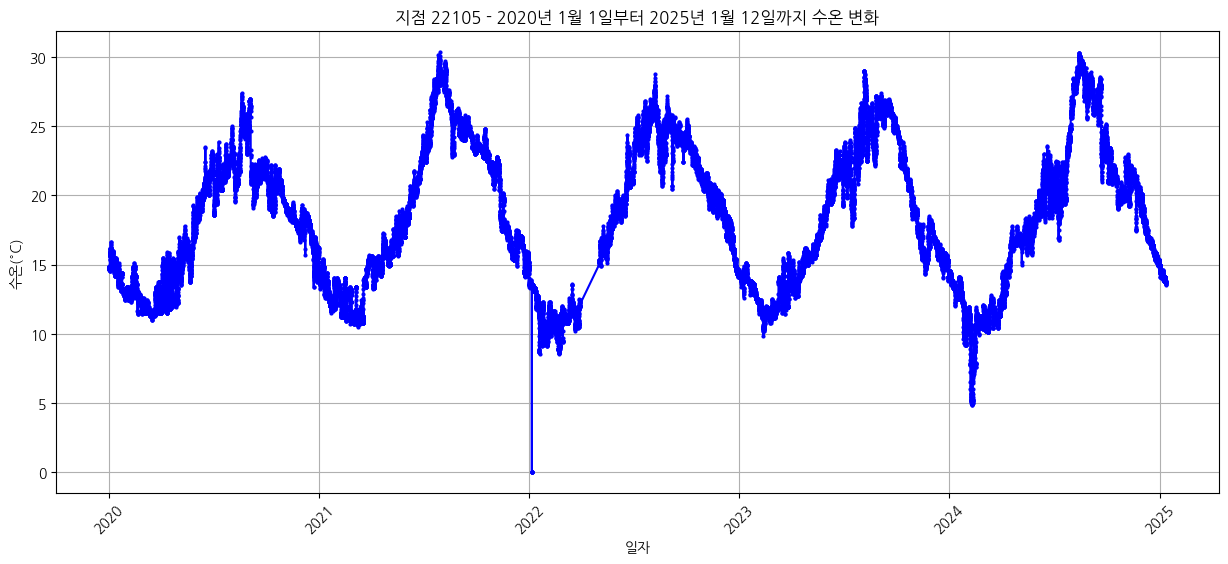

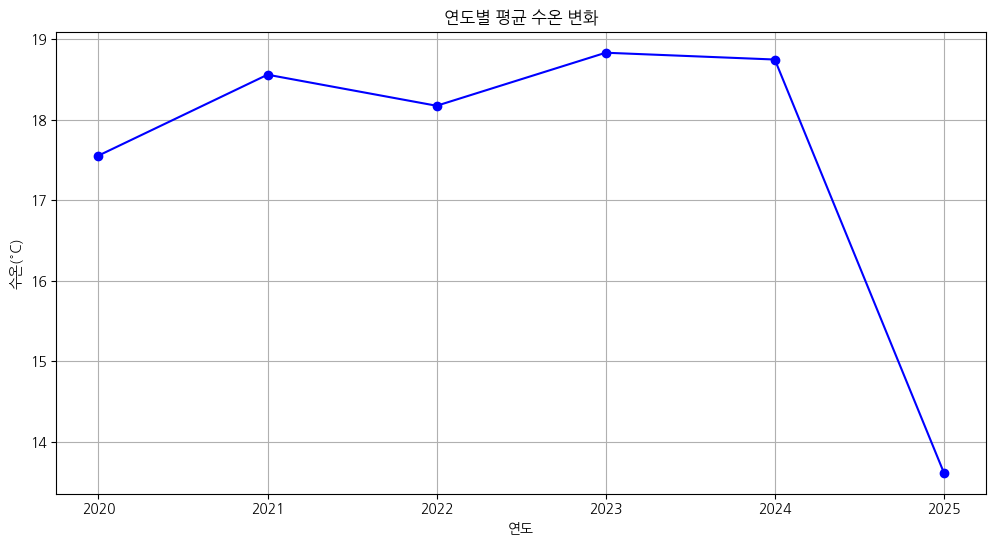

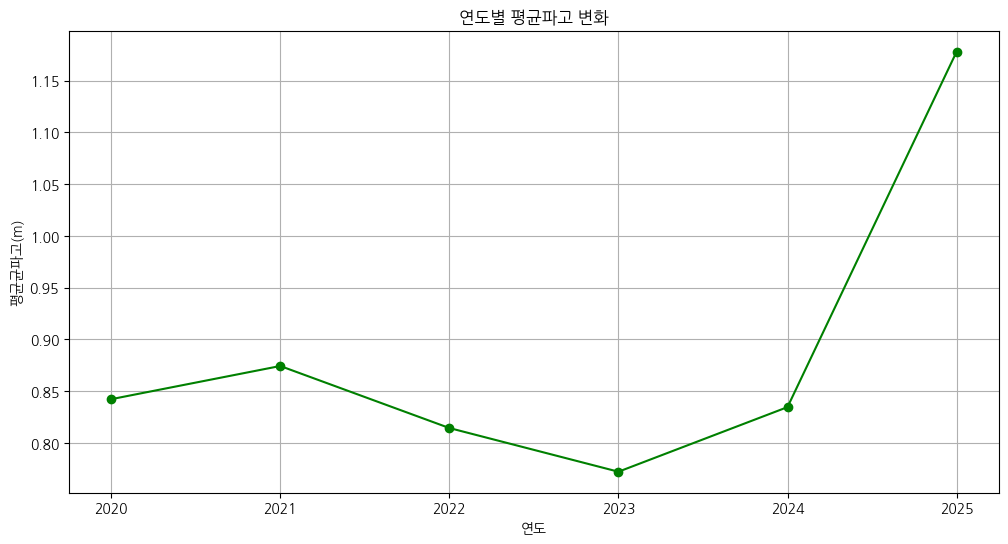

In [6]:
# 1️⃣ 지점 22105 데이터 필터링 (2020년 1월 1일부터 2025년 1월 12일까지)
filtered_df = forecast_df[(forecast_df['지점'] == 22105) & (forecast_df['일시'] >= '2020-01-01') & (forecast_df['일시'] <= '2025-01-12')]

# 2️⃣ '일시'를 인덱스로 설정
filtered_df.set_index('일시', inplace=True)

# 3️⃣ 기온 변화 시각화
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['기온(°C)'], color='orange', linestyle='-', marker='o', markersize=2)
plt.title('지점 22105 - 2020년 1월 1일부터 2025년 1월 12일까지 기온 변화')
plt.xlabel('일자')
plt.ylabel('기온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 4️⃣ 수온 변화 시각화
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['수온(°C)'], color='blue', linestyle='-', marker='o', markersize=2)
plt.title('지점 22105 - 2020년 1월 1일부터 2025년 1월 12일까지 수온 변화')
plt.xlabel('일자')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
yearly_temp = forecast_df.groupby('연도')['수온(°C)'].mean()
plt.plot(yearly_temp.index, yearly_temp.values, marker='o', color='blue')
plt.title('연도별 평균 수온 변화')
plt.xlabel('연도')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
hourly_wave = forecast_df.groupby('연도')['평균파고(m)'].mean()
plt.plot(hourly_wave.index, hourly_wave.values, marker='o', color='green')
plt.title('연도별 평균파고 변화')
plt.xlabel('연도')
plt.ylabel('평균균파고(m)')
plt.grid(True)
plt.show()

In [38]:
# 파일 경로 설정
redtide_path = '../data/raw/적조데이터.csv'
redtide_df = pd.read_csv(redtide_path)
redtide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   예찰일자        767 non-null    object
 1   발생해역        755 non-null    object
 2   적조생물        767 non-null    object
 3   밀도(개체수/mL)  656 non-null    object
 4   수온(℃)       751 non-null    object
 5   염분          744 non-null    object
 6   좌표          503 non-null    object
dtypes: object(7)
memory usage: 42.1+ KB


In [40]:
# 발생해역 범주화 함수 수정
def categorize_region(region):
    if pd.isna(region):  # NaN 값 처리
        return 0
    elif '전남' in region:
        return 1
    elif '울산' in region:
        return 2
    elif '경남' in region:
        return 3
    elif '부산' in region:
        return 4
    elif '제주' in region:
        return 5
    else:
        return 0  # 기타 또는 결측치

# 적용
redtide_df['발생해역_범주'] = redtide_df['발생해역'].apply(categorize_region)
redtide_df.drop(['발생해역','적조생물'], axis=1, inplace=True)
redtide_df.head()

,예찰일자,밀도(개체수/mL),수온(℃),염분,좌표,발생해역_범주
0,2024-09-10,0~0,26~30.2,31.1~32.7,NaN,0
1,2024-09-09,0~0,26.1~29.7,30.7~32.7,NaN,0
2,2024-09-08,0~0,26.2~28.6,30.8~32.6,NaN,0
3,2024-09-07,0~0,25.1~29.1,30.1~32.6,NaN,0
4,2024-09-06,0~0,25.5~29.1,31~32.6,NaN,0


In [41]:
# 3. 적조생물 범주화
redtide_df['적조생물_범주'] = redtide_df['적조생물'].replace({
    'Mesodinium rubrum': 1, 'Noctiluca sp.': 2, 'Cochlodinium polykrikoides': 3, '없음': 0
}).fillna(0)

KeyError: '적조생물'

In [19]:


# 4. 밀도: 숫자~숫자 중간값 계산
def get_midpoint(value):
    try:
        low, high = map(float, value.split('~'))
        return (low + high) / 2
    except:
        return np.nan

redtide_df['밀도_중간값'] = redtide_df['밀도(개체수/mL)'].apply(get_midpoint)

# 5. 수온: 숫자~숫자 중간값 계산 및 결측치 처리
redtide_df['수온_중간값'] = redtide_df['수온(°C)'].apply(get_midpoint)
redtide_df['수온_중간값'] = redtide_df['수온_중간값'].fillna(redtide_df['수온_중간값'].mean())

# 6. 염분: 숫자~숫자 중간값 계산 및 결측치 처리
redtide_df['염분_중간값'] = redtide_df['염분'].apply(get_midpoint)
redtide_df['염분_중간값'] = redtide_df['염분_중간값'].fillna(redtide_df['염분_중간값'].mean())

# 7. 좌표 처리
# 좌표는 발생해역 범주와 연관 지어 평균 좌표로 처리하는 방식 시도
def process_coordinates(coord_str):
    if pd.isna(coord_str):
        return np.nan
    try:
        coords = coord_str.strip('[]').split(',')
        return [float(coords[0]), float(coords[1])]
    except:
        return np.nan

redtide_df['좌표'] = redtide_df['좌표'].apply(process_coordinates)

# 사용자에게 DataFrame 표시
import ace_tools as tools
tools.display_dataframe_to_user(name="Processed Red Tide Data", dataframe=redtide_df)

NameError: name 'np' is not defined

### 이하 해양환경측정망(용존산소량)

In [7]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import os
current_dir = os.getcwd()
sys.path.append(current_dir)  # 루트 디렉터리 경로 추가  # .py
sys.path.append(os.path.dirname(current_dir))  # 상위 디렉터리 경로 추가  # .ipynb
from configs.API import api_key


In [ ]:
# API 엔드포인트 및 인증키 설정
endpoint = "http://apis.data.go.kr/B553931/service/OceansNemoService2"

# 요청 파라미터 설정
params = {
    "serviceKey": api_key,         # 필수: 인증키 (Decoding된 키 사용)
    "numOfRows": 100,              # 선택: 한 페이지에 몇 개의 결과를 받을지 설정
    "pageNo": 1,                   # 선택: 페이지 번호 (기본값은 1)
    "resultType": "xml",           # 선택: 결과 형식 (xml 또는 json 중 선택 가능)
}

response = requests.get(
    url="http://apis.data.go.kr/B553931/service/OceansNemoService2/getOceansNemo2",
    params={
        'ServiceKey': api_key
    }
)

# API 호출
# response = requests.get(endpoint, params=params)

# 응답 확인 및 출력
if response.status_code == 200:
    print("API 호출 성공")
    print(response.text)  # XML 또는 JSON 형태의 결과 출력
else:
    print(f"API 호출 실패. 상태 코드: {response.status_code}")

In [8]:
# API 호출
response = requests.get(
    url="http://apis.data.go.kr/B553931/service/OceansNemoService2/getOceansNemo2",
    params={
        'ServiceKey': api_key
    }
)

# 응답 확인
if response.status_code == 200:
    print("API 호출 성공")
    
    # XML 파싱
    root = ET.fromstring(response.text)
    data = []
    
    # 필요한 데이터를 추출하여 DataFrame 생성
    for item in root.findall(".//item"):
        row = {
            "num": item.findtext("num"),
            "oceanCode": item.findtext("oceanCode"),
            "oceanNm": item.findtext("oceanNm"),
            "stnpntCode": item.findtext("stnpntCode"),
            "stnpntKoreanNm": item.findtext("stnpntKoreanNm"),
            "obsrYear": item.findtext("obsrYear"),
            "obsrMt": item.findtext("obsrMt"),
            "wtrtmpSfclyr": item.findtext("wtrtmpSfclyr"),
            "wtrtmpBtmlyr": item.findtext("wtrtmpBtmlyr"),
            "salntSfclyr": item.findtext("salntSfclyr"),
            "salntBtmlyr": item.findtext("salntBtmlyr")
        }
        data.append(row)
    
    # DataFrame 변환
    df = pd.DataFrame(data)
    
    # DataFrame 출력
    print(df)
else:
    print(f"API 호출 실패. 상태 코드: {response.status_code}")


API 호출 성공
  num oceanCode oceanNm stnpntCode stnpntKoreanNm obsrYear obsrMt  \
0   1        01      동해     010101            거진1     1997     02   
1   2        03      서해     031513           인천13     1997     02   
2   3        01      동해     010201            속초1     1997     02   
3   4        03      서해     031510           인천10     1997     02   
4   5        01      동해     010203            속초3     1997     02   
5   6        03      서해     031508            인천8     1997     02   
6   7        01      동해     010502            강릉2     1997     02   
7   8        03      서해     031507            인천7     1997     02   
8   9        02      남해     020101            울산1     1997     02   
9  10        03      서해     031505            인천5     1997     02   

  wtrtmpSfclyr wtrtmpBtmlyr salntSfclyr salntBtmlyr  
0        6.200        5.500      33.790      33.610  
1        2.400        2.200      32.410      32.360  
2        6.100        5.260      33.730      33.690  
3        2.500